In [30]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram

import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

In [31]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

def display_spectrogram(audio_array: np.ndarray):
  plt.specgram(audio_array, NFFT=400, Fs=SAMPLE_RATE)
  plt.show()

In [32]:
NUM_EPOCHS = 1
NUM_STEPS = 10000

BATCH_SIZE = 4

DURATION = 3000
SHIFT = 10

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [33]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.num_mels = 64
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    self.ms = MelSpectrogram(SAMPLE_RATE, n_mels=self.num_mels)
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark/{folder_name}"):
        if not fn.endswith(".wav"): continue
        waveform, sample_rate = torchaudio.load(f"./data/bark/{folder_name}/{fn}")
        self.voices[-1].append(waveform.view(-1, 1))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices) * self.k)
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim].view(1, -1)).numpy())
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(self.ms(t[r:r + self.embedding_dim].view(1, -1)).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim].view(1, -1)).numpy())
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim].view(1, -1)).float()).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [34]:
dataset = VoiceDataset("./data/bark")
torch.save(dataset, "./checkpoints/bark_dataset.pt")

In [35]:
dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

In [36]:
class Judge(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq1 = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(4),
      nn.ReLU(True),
      nn.Conv2d(64, 128, 2),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2),
      nn.ReLU(True),
      nn.Conv2d(128, 256, 2),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(2),
      nn.ReLU(True)
    )
    self.lstm = nn.LSTM(256, 256, 1, batch_first=True, bidirectional=True)
    self.seq2 = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq3 = nn.Sequential(
      nn.Linear(256 * 40, 256),
      nn.ReLU(True),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs2 = self.seq1(target.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs1, _ = self.lstm(outputs1.squeeze(2).permute(0, 2, 1))
    outputs2, _ = self.lstm(outputs2.squeeze(2).permute(0, 2, 1))
    outputs1 = self.seq2(outputs1)
    outputs2 = self.seq2(outputs2)
    outputs = self.seq3(torch.cat((outputs1, outputs2), dim=1))
    return outputs

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.judge = Judge()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

In [37]:
samples, targets, labels = next(iter(dataloader))
model = Model()
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 10, 64, 361]) torch.Size([4, 10, 64, 361])
tensor([[0.1001, 0.1000, 0.1000, 0.0999, 0.0999, 0.1002, 0.0997, 0.1000, 0.1000,
         0.1001],
        [0.0999, 0.0998, 0.1002, 0.1000, 0.1000, 0.0999, 0.1000, 0.1003, 0.0999,
         0.1000],
        [0.1001, 0.1003, 0.0993, 0.0999, 0.0999, 0.0999, 0.1002, 0.1003, 0.0999,
         0.1002],
        [0.0999, 0.1003, 0.1000, 0.0999, 0.1001, 0.1000, 0.0999, 0.1001, 0.0999,
         0.0999]], grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(2.3025, grad_fn=<DivBackward1>)


100/10000:	2.3026
200/10000:	2.3025
300/10000:	2.3024
400/10000:	2.3020
500/10000:	2.3010
600/10000:	2.2980
700/10000:	2.2923
800/10000:	2.2825
900/10000:	2.2810
1000/10000:	2.2762
1100/10000:	2.2685
1200/10000:	2.2674
1300/10000:	2.2639
1400/10000:	2.2585
1500/10000:	2.2561
1600/10000:	2.2506
1700/10000:	2.2491
1800/10000:	2.2484
1900/10000:	2.2471
2000/10000:	2.2473
2100/10000:	2.2437
2200/10000:	2.2444
2300/10000:	2.2413
2400/10000:	2.2404
2500/10000:	2.2444
2600/10000:	2.2356
2700/10000:	2.2391
2800/10000:	2.2376
2900/10000:	2.2391
3000/10000:	2.2359
3100/10000:	2.2365
3200/10000:	2.2395
3300/10000:	2.2373
3400/10000:	2.2363
3500/10000:	2.2339
3600/10000:	2.2322
3700/10000:	2.2331
3800/10000:	2.2369
3900/10000:	2.2273
4000/10000:	2.2317
4100/10000:	2.2302
4200/10000:	2.2325
4300/10000:	2.2334
4400/10000:	2.2311
4500/10000:	2.2334
4600/10000:	2.2355
4700/10000:	2.2336
4800/10000:	2.2303
4900/10000:	2.2304
5000/10000:	2.2283
5100/10000:	2.2289
5200/10000:	2.2321
5300/10000:	2.2303
54

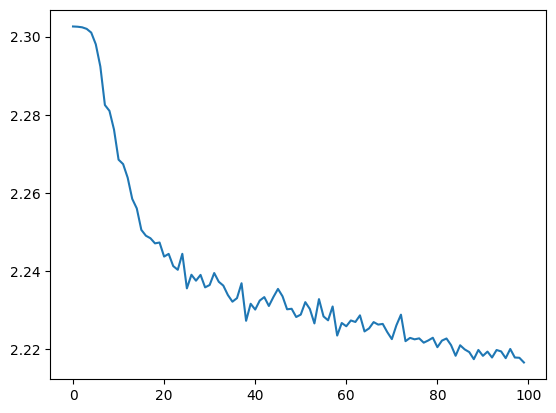

In [38]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model()
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []
display_losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    display_losses.append(np.mean(losses))
    print(f"{step}/{NUM_STEPS}:\t{display_losses[-1]:.4f}")
    losses = []
print("Training Ended!")
plt.plot(display_losses)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Kui\AppData\Local\Temp\ipykernel_43852\696373266.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim].view(1, -1)).float()).numpy())


array([[0.17605011, 0.06947306, 0.069677  , 0.12765306, 0.1820551 ,
        0.08018806, 0.07137387, 0.08449444, 0.06957071, 0.06946458]])

array([474.,   0.,   0.,  77., 431.,   8.,   0.,  10.,   0.,   0.])

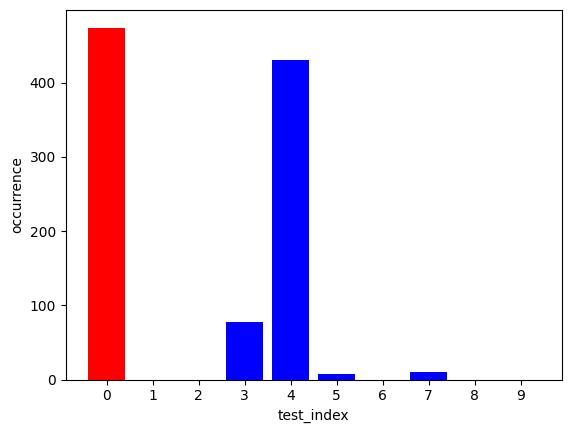

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07467584, 0.18945882, 0.18092445, 0.08034573, 0.07366413,
        0.10675358, 0.07354436, 0.07354437, 0.07354436, 0.07354436]])

array([  0., 531., 428.,   3.,   0.,  38.,   0.,   0.,   0.,   0.])

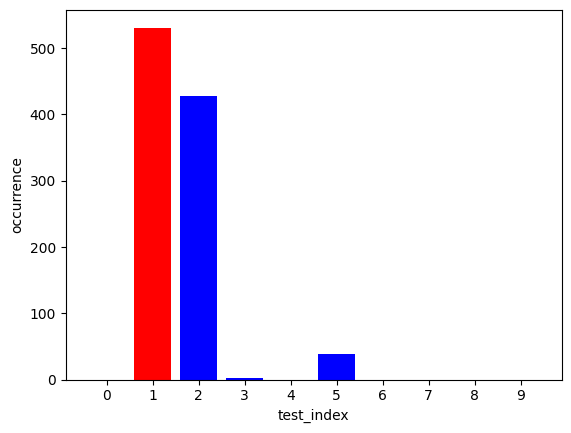

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07438214, 0.20061314, 0.19770869, 0.07481386, 0.07418756,
        0.08154436, 0.07418756, 0.07418756, 0.07418756, 0.07418756]])

array([  0., 462., 536.,   1.,   0.,   1.,   0.,   0.,   0.,   0.])

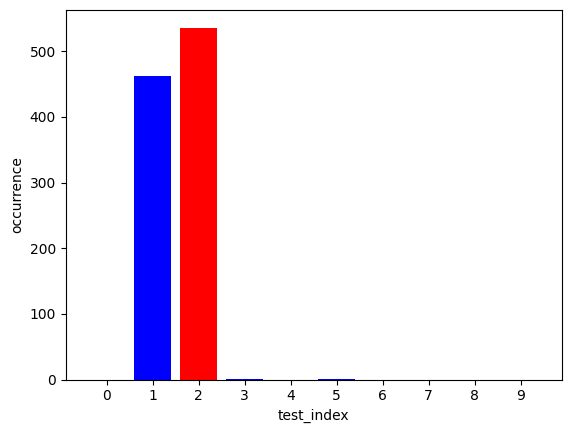

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09470516, 0.08761894, 0.08225556, 0.15891558, 0.07916688,
        0.19823374, 0.07476557, 0.07480744, 0.07476557, 0.07476557]])

array([ 27.,  13.,   9., 138.,   2., 811.,   0.,   0.,   0.,   0.])

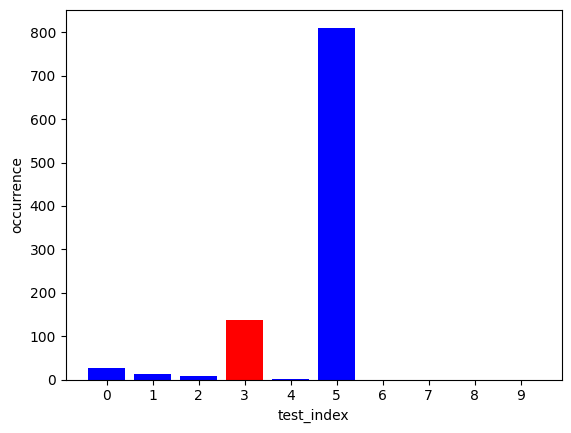

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.14751249, 0.06664531, 0.06759118, 0.17428915, 0.1446263 ,
        0.13151986, 0.06648213, 0.06841847, 0.06645755, 0.06645755]])

array([251.,   0.,   6., 493., 105., 144.,   0.,   1.,   0.,   0.])

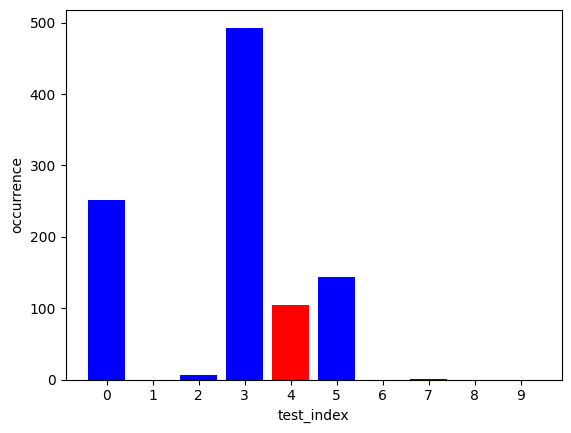

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09159293, 0.10915049, 0.09518767, 0.13899794, 0.08081853,
        0.18706126, 0.07429592, 0.07430349, 0.07429589, 0.07429589]])

array([ 27.,  89.,  52., 137.,   2., 693.,   0.,   0.,   0.,   0.])

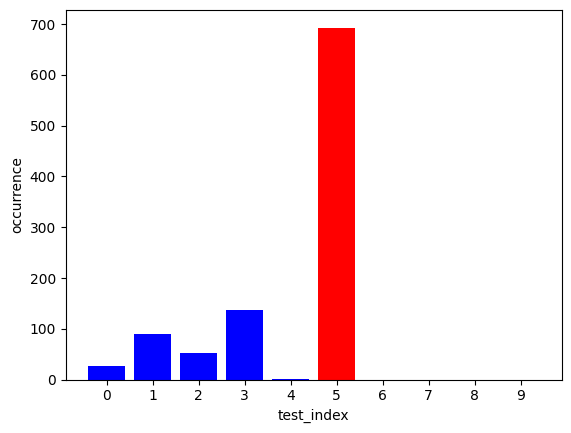

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.13524581, 0.07017909, 0.0703008 , 0.09476644, 0.13276139,
        0.07988935, 0.12538817, 0.14778876, 0.0730716 , 0.07060858]])

array([243.,   1.,   1.,  98., 194.,  33., 136., 291.,   3.,   0.])

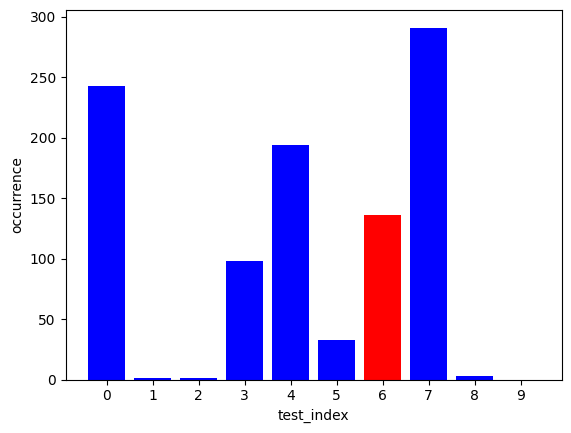

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.12451608, 0.0716748 , 0.07169313, 0.07564069, 0.11722766,
        0.07223673, 0.14339194, 0.17878703, 0.07315284, 0.07167911]])

array([157.,   0.,   0.,   3., 107.,   1., 148., 583.,   1.,   0.])

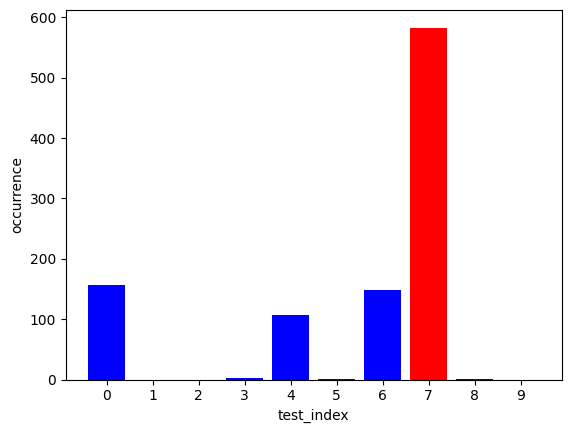

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07286816, 0.07160247, 0.07271755, 0.07160268, 0.07239639,
        0.07412428, 0.11533844, 0.08895897, 0.18051561, 0.17987545]])

array([  0.,   0.,   3.,   0.,   1.,  11.,  72.,  27., 420., 466.])

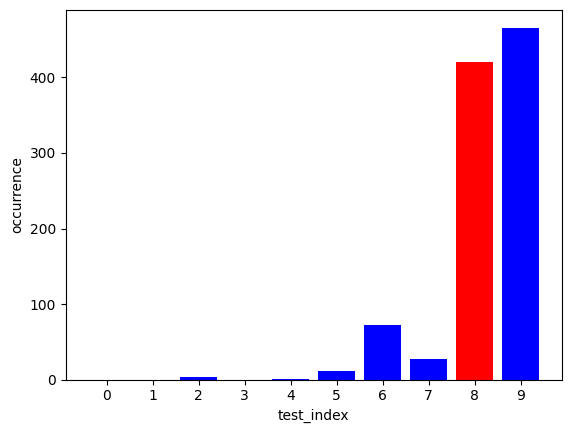

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07624252, 0.07266232, 0.07325657, 0.07266359, 0.07416985,
        0.07363449, 0.17268202, 0.149173  , 0.12167256, 0.11384307]])

array([  5.,   0.,   1.,   0.,   3.,   4., 491., 264., 109., 123.])

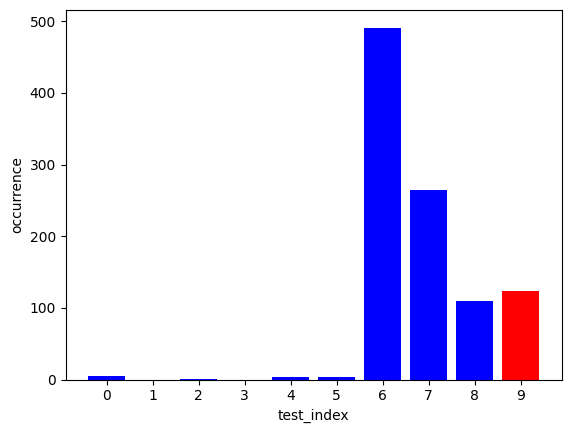

In [40]:
num_validation = 1000
test_cases = ["man-1", "man-2", "man-3", "man-4", "man-5", "woman-1", "woman-2", "woman-3", "woman-4", "woman-5"]

with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t, _ = torchaudio.load(f"./data/bark/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t.view(-1, 1))
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [8]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
preload_models(use_smaller_models=True)

In [9]:
raw_prompts = [
  "A pessimist is one who makes difficulties of his opportunities and an optimist is one who makes opportunities of his difficulties.",
  "Don't judge each day by the harvest you reap but by the seeds that you plant.",
  "Challenges are what make life interesting and overcoming them is what makes life meaningful.",
  "Happiness lies not in the mere possession of money; it lies in the joy of achievement, in the thrill of creative effort.",
  "I disapprove of what you say, but I will defend to the death your right to say it.",
  "If I looked compared to others far, is because I stand on giant's shoulder.",
  "Never argue with stupid people, they will drag you down to their level and then beat you with experience.",
  "The greatest glory in living lies not in never falling, but in rising every time we fall.",
  "When you look into the abyss, the abyss also looks into you.",
  "Whoever fights monsters should see to it that in the process he does not become a monster."
]

basename = "woman-2"

for i, raw_prompt in enumerate(raw_prompts):
  generate(basename, raw_prompt, i)

woman-2: prompt-0
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.02it/s]


woman-2: prompt-1
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


woman-2: prompt-2
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.00it/s]


woman-2: prompt-3
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


woman-2: prompt-4
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


woman-2: prompt-5
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


woman-2: prompt-6
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


woman-2: prompt-7
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


woman-2: prompt-8
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


woman-2: prompt-9
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
